## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['SNORKELDB'] = 'postgres:///babble_spouse_demo'

In [3]:
from snorkel import SnorkelSession
session = SnorkelSession()

In [4]:
from snorkel.contrib.babble.models import configuration

config = configuration
config['domain'] = 'spouse'
config['splits'] = [0,1,2]
config['parallelism'] = 6
config['verbose'] = True
config['display_learned_accuracies'] = False

In [5]:
from snorkel.models import candidate_subclass
from snorkel.contrib.babble import ExplanationIO
from tutorials.babble.spouse import SpouseModel

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])
candidate_class = Spouse
sm = SpouseModel(session, Spouse, config)

## Parse, Extract, Load Gold

In [6]:
%time sm.parse()

In [7]:
%time sm.extract()

In [8]:
%time sm.load_gold()

##  Gather Explanations

Here we load a number of pre-built lists that the user can refer to when writing explanations.

In [9]:
from tutorials.babble.spouse.spouse_examples import get_user_lists
user_lists = get_user_lists()
print("User lists: {}".format(user_lists.keys()))

User lists: ['known_spouses', 'spouse', 'other', 'family', 'last_names']


For example, the 'spouse' list contains a number of spouse-related words:

In [10]:
user_lists['spouse']

['spouse', 'wife', 'husband', 'ex-wife', 'ex-husband']

We have written 10 explanations as a starting point. We 'link' them to the candidates that they refer to by storing with each one a pointer to the candidate that the explanation was given in reference to.

In [11]:
candidates = session.query(candidate_class).filter(
    candidate_class.split == config['babbler_candidate_split']).all()

In [12]:
from tutorials.babble.spouse.spouse_examples import get_explanations
explanations = get_explanations(candidates)

Building list of target candidate ids...
Collected 11 unique target candidate ids from 11 explanations.
Gathering desired candidates...
Found 11/11 desired candidates
Linking explanations to candidates...
Linked 11/11 explanations


In [13]:
for exp in explanations:
    print(exp.condition)

there is a spouse word between arg 1 and arg 2
there is a spouse word within two words to the left of arg 1 or arg 2
there are no spouse words in the sentence
the word 'and' is between arg 1 and arg 2 and 'married' or 'marriage' is after arg 2
there is a family word between arg 1 and arg 2
there is a family word within three words to the left of arg 1 or arg 2
there is an other word between arg 1 and arg 2
either the pair of arg 1 and arg 2 or the pair arg 2 and arg 1 is in known_spouses
the number of words between arg 1 and arg 2 is larger than 10
there is a person between arg 1 and arg 2
arg 1 is identical to arg 2


## Apply Filter Bank

This step can be executed all at once with a single command:

```sm.babble(explanations, user_lists=user_lists, config=config)```

Because we would like to inspect the results between each step for illustration purposes, however, we will break it up into intermediate steps.

First, we create a ```Babbler``` object.

In [14]:
from snorkel.contrib.babble import Babbler

babbler = Babbler(mode='text', 
                  explanations=explanations, 
                  candidate_class=candidate_class, 
                  user_lists=user_lists)

Created grammar with 480 rules


No we use our semantic parser to convert the explanations into labeling functions (LFs).

In [15]:
lfs = babbler.generate_lfs()

24 parses created from 11 out of 11 explanation(s)
Parsed 24 LFs from 11 explanations.


Due to the ambiguity of natural language, we have more than twice as many candidate LFs as explanations. We now apply the filters in our filter bank to remove as many spurious LFs as possible without requiring additional labels.

First, if any parses have identical semantics (i.e., they represent the same program), remove all but one copy.

In [16]:
babbler.filter_duplicate_semantics()

Filtered to 20 LFs with duplicate semantics filter (4 filtered).


Next, remove any candidate LFs who label their accompanying candidate inconsistently with the label the user gave when providing the explanation.

In [17]:
babbler.filter_consistency()

Filtered to 13 LFs with consistency filter (7 filtered).


Now apply the remaining LFs to the full candidate set to observe their labeling signatures.

In [18]:
babbler.generate_label_matrix(split=0)

Clearing existing...
Running UDF...
[========================================] 100%



<23490x13 sparse matrix of type '<type 'numpy.int64'>'
	with 92389 stored elements in Compressed Sparse Row format>

Remove any LFs that label all candidates True or all candidates False. (In this case, either no LFs of this type were generated or they were removed by previous filters).

In [19]:
babbler.filter_uniform_signatures()

Filtered to 13 LFs with uniform signatures filter (0 filtered).


Then remove any LFs that have a duplicate labeling signature (i.e., even though they are technically different programs, since they have different semantics, they are effectively the same in this domain and therefore provide no unique information).

In [20]:
babbler.filter_duplicate_signatures()

Filtered to 10 LFs with duplicate signatures filter (3 filtered).


The actual parsed labeling functions are lambda functions ready to operate on candidates, which are hard to interpret directly. We can, however, view the explicit semantics of the remaining LFs or pseudocode versions of them (default).

In [21]:
babbler.get_parses(translate=True)

["return 1 if (call(in text(between([arg1,arg2])), 'and') and any(map(in text(right(arg2)), ['married','marriage']))) else 0",
 "return 1 if any(map(in $'known_spouses'$, [tuple([text(arg1),text(arg2)]),tuple([text(arg2),text(arg1)])])) else 0",
 "return -1 if any(map(in text(left(arg2,'.leq',3,'words')), $'family'$)) else 0",
 'return -1 if call((= text(arg2)), text(arg1)) else 0',
 "return -1 if call((= 0), sum(map(in text(sentence()), $'spouse'$))) else 0",
 "return -1 if any(map(in text(between([arg1,arg2])), $'other'$)) else 0",
 'return 1 if call((>= 1), count(filter(between([arg1,arg2]), words, \\w+\\S*))) else 0',
 "return 1 if any(map(in text(left(arg2,'.leq',2,'words')), $'spouse'$)) else 0",
 'return -1 if call((>= 1), count(filter(between([arg1,arg2]), ner_tags, PERSON))) else 0',
 'return -1 if call((> 10), count(between([arg1,arg2]))) else 0']

These parses correspond to the following explanations:

In [22]:
babbler.get_explanations()

[Explanation("LF_arg1_and_arg2_married: True, the word 'and' is between arg 1 and arg 2 and 'married' or 'marriage' is after arg 2"),
 Explanation("LF_distant: True, either the pair of arg 1 and arg 2 or the pair arg 2 and arg 1 is in known_spouses"),
 Explanation("LF_family_to_left: False, there is a family word within three words to the left of arg 1 or arg 2"),
 Explanation("LF_identical_args: False, arg 1 is identical to arg 2"),
 Explanation("LF_no_spouse_in_sentence: False, there are no spouse words in the sentence"),
 Explanation("LF_other_between: False, there is an other word between arg 1 and arg 2"),
 Explanation("LF_spouse_between: True, there is a spouse word between arg 1 and arg 2"),
 Explanation("LF_spouse_to_left: True, there is a spouse word within two words to the left of arg 1 or arg 2"),
 Explanation("LF_third_wheel: False, there is a person between arg 1 and arg 2"),
 Explanation("LF_too_far_apart: False, the number of words between arg 1 and arg 2 is larger than 

We now store the results from the Babbler in the SpouseModel object for the sake of later stages in the pipeline.

In [23]:
from snorkel.annotations import LabelAnnotator

sm.babbler = babbler
sm.lfs = babbler.lfs
sm.labeler = LabelAnnotator(lfs=babbler.lfs)

## Aggregate Labels

In [24]:
%time sm.label(config=config)

Clearing existing...
Running UDF...

Labeled split 0: (23490,10) sparse (nnz = 66916)
Clearing existing...
Running UDF...

Labeled split 1: (2456,10) sparse (nnz = 7156)
CPU times: user 43.3 s, sys: 5.65 s, total: 49 s
Wall time: 1min 40s


/Users/bradenjh/repos/snorkel/snorkel/annotations.py:129: RuntimeWarning: invalid value encountered in divide
  ac = (tp+tn).astype(float) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_spouse_between_0,0,0.964984,0.940554,0.919788,174,2112,0,0,0.076115
LF_spouse_to_left_0,1,0.051303,0.051303,0.030945,79,45,0,0,0.637097
LF_no_spouse_in_sentence_0,2,0.822068,0.795195,0.792752,0,0,59,1884,0.969635
LF_arg1_and_arg2_married_3,3,0.009772,0.009772,0.008143,10,13,0,0,0.434783
LF_family_to_left_0,4,0.077769,0.077362,0.076140,0,0,7,174,0.961326
LF_other_between_0,5,0.026873,0.026873,0.026873,0,0,3,62,0.953846
LF_distant_0,6,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_too_far_apart_0,7,0.556596,0.556596,0.556596,0,0,75,1242,0.943052
LF_third_wheel_0,8,0.355456,0.355456,0.355456,0,0,32,813,0.962130
LF_identical_args_0,9,0.048860,0.048453,0.047231,0,0,0,118,1.000000


Inferred cardinality: 2


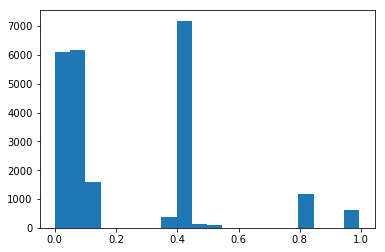

CPU times: user 1min 16s, sys: 350 ms, total: 1min 16s
Wall time: 1min 16s


In [25]:
%time sm.supervise(config=config)

## Classify

In [26]:
%time sm.classify()

/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 12 has argument past max length for model:	[arg ends at index 148; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:35: UserWarning: Additional warnings of this nature will be suppressed.
  warnings.warn('Additional warnings of this nature will be suppressed.')
/Users/bradenjh/anaconda/envs/snorkel/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=3606  #epochs=10  batch size=256
[reRNN] Epoch 0 (5.56s)	Average loss=0.670643	Dev F1=23.46
[reRNN] Epoch 1 (12.41s)	Average loss=0.521573	Dev F1=27.11
[reRNN] Epoch 2 (19.41s)	Average loss=0.471161	Dev F1=26.57
[reRNN] Epoch 3 (26.18s)	Average loss=0.438976	Dev F1=27.42
[reRNN] Epoch 4 (33.05s)	Average loss=0.427171	Dev F1=31.98
[reRNN] Epoch 5 (39.86s)	Average loss=0.413283	Dev F1=31.27
[reRNN] Epoch 6 (46.72s)	Average loss=0.402271	Dev F1=29.92
[reRNN] Epoch 7 (53.46s)	Average loss=0.399271	Dev F1=31.13
[reRNN] Epoch 8 (60.36s)	Average loss=0.393220	Dev F1=31.87
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (68.72s)	Average loss=0.389077	Dev F1=29.06
[reRNN] Training done (70.06s)
[reRNN] Loaded model <reRNN>

Dev:


/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 72 has argument past max length for model:	[arg ends at index 103; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))


Prec: 0.215, Recall: 0.612, F1 Score: 0.319

Test:


/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 51 has argument past max length for model:	[arg ends at index 110; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))


Prec: 0.183, Recall: 0.720, F1 Score: 0.291
Scores (Un-adjusted)
Pos. class accuracy: 0.72
Neg. class accuracy: 0.711
Precision            0.183
Recall               0.72
F1                   0.291
----------------------------------------
TP: 108 | FP: 483 | TN: 1187 | FN: 42

CPU times: user 6min 19s, sys: 36.6 s, total: 6min 56s
Wall time: 2min 2s


In [27]:
test_candidates = session.query(candidate_class).filter(
    candidate_class.split == 2).all()

In [28]:
from snorkel.annotations import load_gold_labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

<1820x1 sparse matrix of type '<type 'numpy.int64'>'
	with 1747 stored elements in Compressed Sparse Row format>

In [29]:
tp, fp, tn, fn = sm.disc_model.error_analysis(session, test_candidates, L_gold_test, b=0.85)

Scores (Un-adjusted)
Pos. class accuracy: 0.373
Neg. class accuracy: 0.958
Precision            0.444
Recall               0.373
F1                   0.406
----------------------------------------
TP: 56 | FP: 70 | TN: 1600 | FN: 94



## Compare to Traditional Supervision

In [30]:
config['traditional'] = 1000

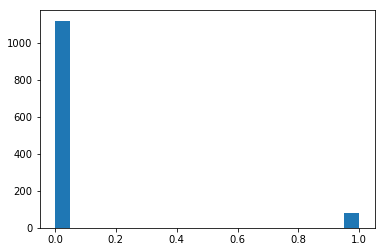

In [31]:
sm.supervise(config=config)

In [32]:
sm.classify()

/Users/bradenjh/repos/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 110 has argument past max length for model:	[arg ends at index 106; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))


[reRNN] Training model
[reRNN] n_train=160  #epochs=10  batch size=160
[reRNN] Epoch 0 (0.30s)	Average loss=0.694234	Dev F1=9.39
[reRNN] Epoch 1 (1.92s)	Average loss=0.683543	Dev F1=13.62
[reRNN] Epoch 2 (3.62s)	Average loss=0.658765	Dev F1=13.63
[reRNN] Epoch 3 (5.46s)	Average loss=0.576774	Dev F1=12.12
[reRNN] Epoch 4 (7.28s)	Average loss=0.514390	Dev F1=13.48
[reRNN] Epoch 5 (9.10s)	Average loss=0.534577	Dev F1=13.62
[reRNN] Epoch 6 (10.89s)	Average loss=0.390462	Dev F1=13.79
[reRNN] Epoch 7 (12.64s)	Average loss=0.396796	Dev F1=12.20
[reRNN] Epoch 8 (14.37s)	Average loss=0.350234	Dev F1=12.79
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (17.70s)	Average loss=0.282759	Dev F1=12.71
[reRNN] Training done (19.09s)
[reRNN] Loaded model <reRNN>

Dev:
Prec: 0.078, Recall: 0.354, F1 Score: 0.128

Test:
Prec: 0.077, Recall: 0.367, F1 Score: 0.127
Scores (Un-adjusted)
Pos. class accuracy: 0.367
Neg. class accuracy: 0.606
Precision            0.0771
Recall               0.367
F1            

In [33]:
tp, fp, tn, fn = sm.disc_model.error_analysis(session, test_candidates, L_gold_test, b=0.05)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.0824
Recall               1.0
F1                   0.152
----------------------------------------
TP: 150 | FP: 1670 | TN: 0 | FN: 0



## Adding More Explanations

In [34]:
train_candidates = session.query(candidate_class).filter(
    candidate_class.split == 0).all()

In [35]:
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer(train_candidates[500:600], session, n_per_page=3, height=300)
sv

<IPython.core.display.Javascript object>

In [36]:
from snorkel.contrib.babble import Explanation

babbler.add_explanations(
    Explanation(
        label=False,
        condition="'role as' is between arg 1 and arg 2",
        candidate=sv.get_selected()
    )
)